# 이론
자연어는 세 종류로 구분된다.  
- 고립어
  - 중국어와 같이 **단어의 형태**가 **고정**된 형태의 언어.
- 굴절어
  - 영어, 독일어와 같이 **시제, 인칭 변화 등에 따라 단어의 형태가 변하는** 언어
- 교착어
  - 한국어와 같이 **단어에 어미가 붙어 시제, 인칭 등의 뜻이 최종 결정**되는 언어
##### 한국어 텍스트 토큰화는 어렵다.
- 띄어쓰기로 split하여 토큰화를 하면 단어에 조사가 붙게된다.   
**어미로 붙는 조사가 다르면 서로 다른 단어로 인식**하게 된다.   
- **띄어쓰기가 잘 지켜지지 않는 corpus**도 많으므로 split 방식으로 만족스러운 토큰을 얻기 어렵다.

그러므로, 한국어 텍스트에서 영어와 유사한 토큰을 얻기 위해 **형태소 단위의 분리가 필요**하다.

##### 형태소 분석기
**형태소, morpheme**이란 의미를 가진 가장 작은 단위의 말이다.   
- 자립 형태소: 접사, 어미, 조사 등과 상관없이 자립해 쓸 수 있는 형태소
- 의존 형태소: 다른 형태소와 결합되어 사용됨. 접사, 어미, 조사 등

한국어 NLP 파이썬 라이브러리 KoNLPy가 널리 쓰이는 형태소 분석 라이브러리이며, 카카오의 딥러닝 기반 khaii, 엑소브레인의 형태소 분석기도 있다.   
여기에선 KoNLPy의 형태소 분석기에 대해 간단히 알아보자.

자주 쓰이는 분석기들은 아래와 같다.   
- **Okt**: Open Korean Text, 트위터 분석기라고 불렸다. 인터넷 용어들도 비교적 분석이 가능하다.
- **Kkma**: 꼬꼬마 형태소 분석기. 어미 분석을 자세히 수행해준다.
- **Mecab**: 일본어 형태소 분석기 Mecab을 한국어로 구현한 것.

- KoNLPy의 형태소 분석기들은 **morphs** 메서드에 문장을 입력해 형태소 분석이 가능하며 **pos** 메서드를 통해 형태소 분석 및 품사 태깅이 가능하다.
  - 품사 태깅: 형태소마다 품사를 예측한 후 **형태소-품사 pair**를 만드는 것을 의미한다.
  - 이를 활용하면 특정 품사를 제거 혹은 잔류시키는 전처리가 가능하다.

In [28]:
from konlpy.tag import Okt
okt = Okt()
print('Okt 형태소 분석 :', okt.morphs('단독입찰보다 복수입찰의 경우'))
print('Okt 품사 태깅: ', okt.pos('이것도 되나욬ㅋㅋ'))

Okt 형태소 분석 : ['단독', '입찰', '보다', '복수', '입찰', '의', '경우']
Okt 품사 태깅:  [('이', 'Determiner'), ('것', 'Noun'), ('도', 'Josa'), ('되나욬', 'Noun'), ('ㅋㅋ', 'KoreanParticle')]


In [29]:
from konlpy.tag import Kkma
kkma = Kkma()
print('Kkma 형태소 분석 :', kkma.morphs('단독입찰보다 복수입찰의 경우'))
print('Kkma 품사 태깅: ', kkma.pos('이것도 되나욬ㅋㅋ'))

Kkma 형태소 분석 : ['단독', '입찰', '보다', '복수', '입찰', '의', '경우']
Kkma 품사 태깅:  [('이것', 'NP'), ('도', 'JX'), ('되', 'VV'), ('나', 'ECE'), ('욬', 'UN'), ('ㅋㅋ', 'EMO')]


확인해보면 분석기마다 품사 코드도 조금씩 다르고, 이에 따른 형태소 분석 결과도 다를 수 있기에 잘 파악하여 활용해야 한다.
##### RNN을 이용한 네이버 영화 리뷰 감성 분석
15만개의 학습 데이터 및 5만개의 테스트 데이터가 존재한다.   
중복 데이터 등 데이터 전처리가 필요한 상태이다.

In [30]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x2a0e82550>)

In [31]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

print('Train data len :', len(train_data))
train_data[:5]

Train data len : 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [32]:
print('Test data len :', len(test_data))
test_data[:5]

Test data len : 50000


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [33]:
# 중복 데이터 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data.groupby('label').size()

label
0    73342
1    72841
dtype: int64

In [34]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글과 공백을 제외하고 모두 제거
# . 제거
# train_data['document'] = train_data['document'].str.replace('.', "")
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [36]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())
train_data.loc[train_data.document.isnull()][:5]
train_data = train_data.dropna(how = 'any') # null값 제거
print(len(train_data))

id          0
document    1
label       0
dtype: int64
146182


In [37]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과',
             '도', '를', '으로', '자', '에', '와', '한', '하다']
okt = Okt()
X_train = []
for sentence in tqdm(train_data['document']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)
print(X_train[:3])

100%|██████████| 146182/146182 [04:26<00:00, 549.35it/s]

[['아', '더빙', '..', '진짜', '짜증나다', '목소리'], ['흠', '...', '포스터', '보고', '초딩', '영화', '줄', '....', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


불용어 정의 및 형태소 분석기를 통한 토큰화를 진행했다.   
- stem=True 옵션으로 형태소 분석을 수행할 시 형태소 원형이 반환된다.
  - ex) **되나요 -> 되다** 와 같은 형식으로 반환되는 형태소가 바뀐다.

In [39]:
X_test = []
for sentence in tqdm(test_data['document']):
  sentence = str(sentence)
  tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
  stopword_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
  X_test.append(stopword_removed_sentence)

100%|██████████| 50000/50000 [01:54<00:00, 438.24it/s]


기본적으로 **각 전처리 및 vocab 생성은 학습 데이터에 대해서**만 이루어진다.   
- 테스트 데이터는 실제 모델 서비스 시 무엇이 들어올 지 모르는 상태로 가정.
- 이에 현재 테스트 데이터는 숫자형 데이터도 존재하는 등 데이터 정제가 되지 않은 상태이므로 string으로 캐스팅 후 토큰화

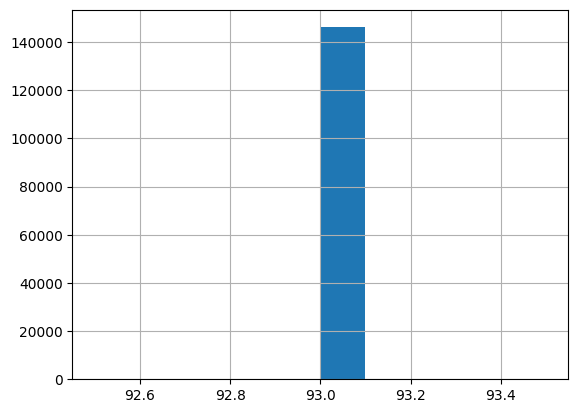

count    146182.0
mean         93.0
std           0.0
min          93.0
25%          93.0
50%          93.0
75%          93.0
max          93.0
dtype: float64

In [50]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

def tokenize(x_train, y_train, x_val, y_val):
    word_list = []
    
    for sentence in x_train:
        for word in sentence:
            word_list.append(word)

    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:10000]
    # creating a dict
    onehot_dict = {w: i+1 for i, w in enumerate(corpus_)}
    
    # tokenize
    final_list_train, final_list_test = [], []
    for s in x_train:
        final_list_train.append([onehot_dict[word] for word in s if word in onehot_dict.keys()])
    for s in x_val:
        final_list_test.append([onehot_dict[word] for word in s if word in onehot_dict.keys()])

    # 패딩을 적용하기 위한 최대 길이 계산
    max_len = max(max(len(s) for s in final_list_train), max(len(s) for s in final_list_test))

    # 패딩 적용
    X_train_padded = pad_sequences(final_list_train, maxlen=max_len, padding='post')
    X_test_padded = pad_sequences(final_list_test, maxlen=max_len, padding='post')
    
    return np.array(X_train_padded), np.array(y_train), np.array(X_test_padded), np.array(y_val), onehot_dict

# 함수 호출
X_train, y_train, X_test, y_test, onehot_dict = tokenize(X_train, train_data['label'], X_test, test_data['label'])

# 길이 분포 확인
rev_len = [len(i) for i in X_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()


In [51]:
def padding_(sentences, seq_len):
  features = np.zeros((len(sentences), seq_len), dtype=int)
  for i, row in enumerate(sentences):
    if len(row) != 0:
      features[i, -len(row):] = np.array(row)[:seq_len]
  return features

X_train_pad = padding_(X_train, 50)
X_test_pad = padding_(X_test, 50)

In [52]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train_pad), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [53]:
class GRU_model(nn.Module):
  def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, device):
    super(GRU_model, self).__init__()
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim
    self.device = device
    
    self.embed = nn.Embedding(n_vocab, embed_dim)
    self.gru = nn.GRU(embed_dim, hidden_dim, n_layers, batch_first=True)
    self.out = nn.Linear(hidden_dim, n_classes)
  
  def forward(self, x):
    x = self.embed(x)
    h_0 = self._init_state(batch_size=x.size(0)) # init first hidden state
    x, _ = self.gru(x, h_0) # GRU's return is batch size, seq length, hidden dim
    h_t = x[:,-1,:] # size changed to batch size, hidden dim, we want time-step's hidden state
    logit = self.out(h_t)
    return logit
    
  def _init_state(self, batch_size):
    new_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(self.device)
    return new_state

In [54]:
is_cuda = torch.cuda.is_available()

if is_cuda:
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [55]:
n_layers = 1
vocab_size = len(onehot_dict) + 1 # +1 for the padding
hidden_dim = 128
embedding_dim = 100
n_classes = 2

model = GRU_model(n_layers, hidden_dim, vocab_size, embedding_dim, n_classes, device).to(device)

In [56]:
def train(model, criterion, optimizer, data_loader):
  model.train()
  train_loss = 0
  for i, (x, y) in enumerate(data_loader):
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logit = model(x)
    loss = criterion(logit, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * x.size(0)

  return train_loss / len(data_loader.dataset)

def evaluate(model, data_loader):
  model.eval()
  corrects, total_loss = 0, 0
  for i, (x, y) in enumerate(data_loader):
    x, y = x.to(device), y.to(device)
    logit = model(x)
    corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
  size = len(data_loader.dataset)

  avg_accuracy = 100.0 * corrects/size
  return avg_accuracy

In [58]:
num_epochs = 10
lr = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for e in range(1, num_epochs + 1):
  train_loss = train(model, criterion, optimizer, train_loader)
  test_accuracy = evaluate(model, test_loader)
  print("[Epoch: %d] Train Loss: %5.2f | Test Accuracy: %5.2f" % (e, train_loss, test_accuracy))

[Epoch: 1] Train Loss:  0.35 | Test Accuracy: 84.87
[Epoch: 2] Train Loss:  0.29 | Test Accuracy: 85.65
[Epoch: 3] Train Loss:  0.24 | Test Accuracy: 85.59
[Epoch: 4] Train Loss:  0.19 | Test Accuracy: 85.45
[Epoch: 5] Train Loss:  0.15 | Test Accuracy: 84.86
[Epoch: 6] Train Loss:  0.12 | Test Accuracy: 84.72
[Epoch: 7] Train Loss:  0.09 | Test Accuracy: 84.56
[Epoch: 8] Train Loss:  0.08 | Test Accuracy: 84.29
[Epoch: 9] Train Loss:  0.07 | Test Accuracy: 84.23
[Epoch: 10] Train Loss:  0.06 | Test Accuracy: 84.03


#### 전체 프로세스 요약
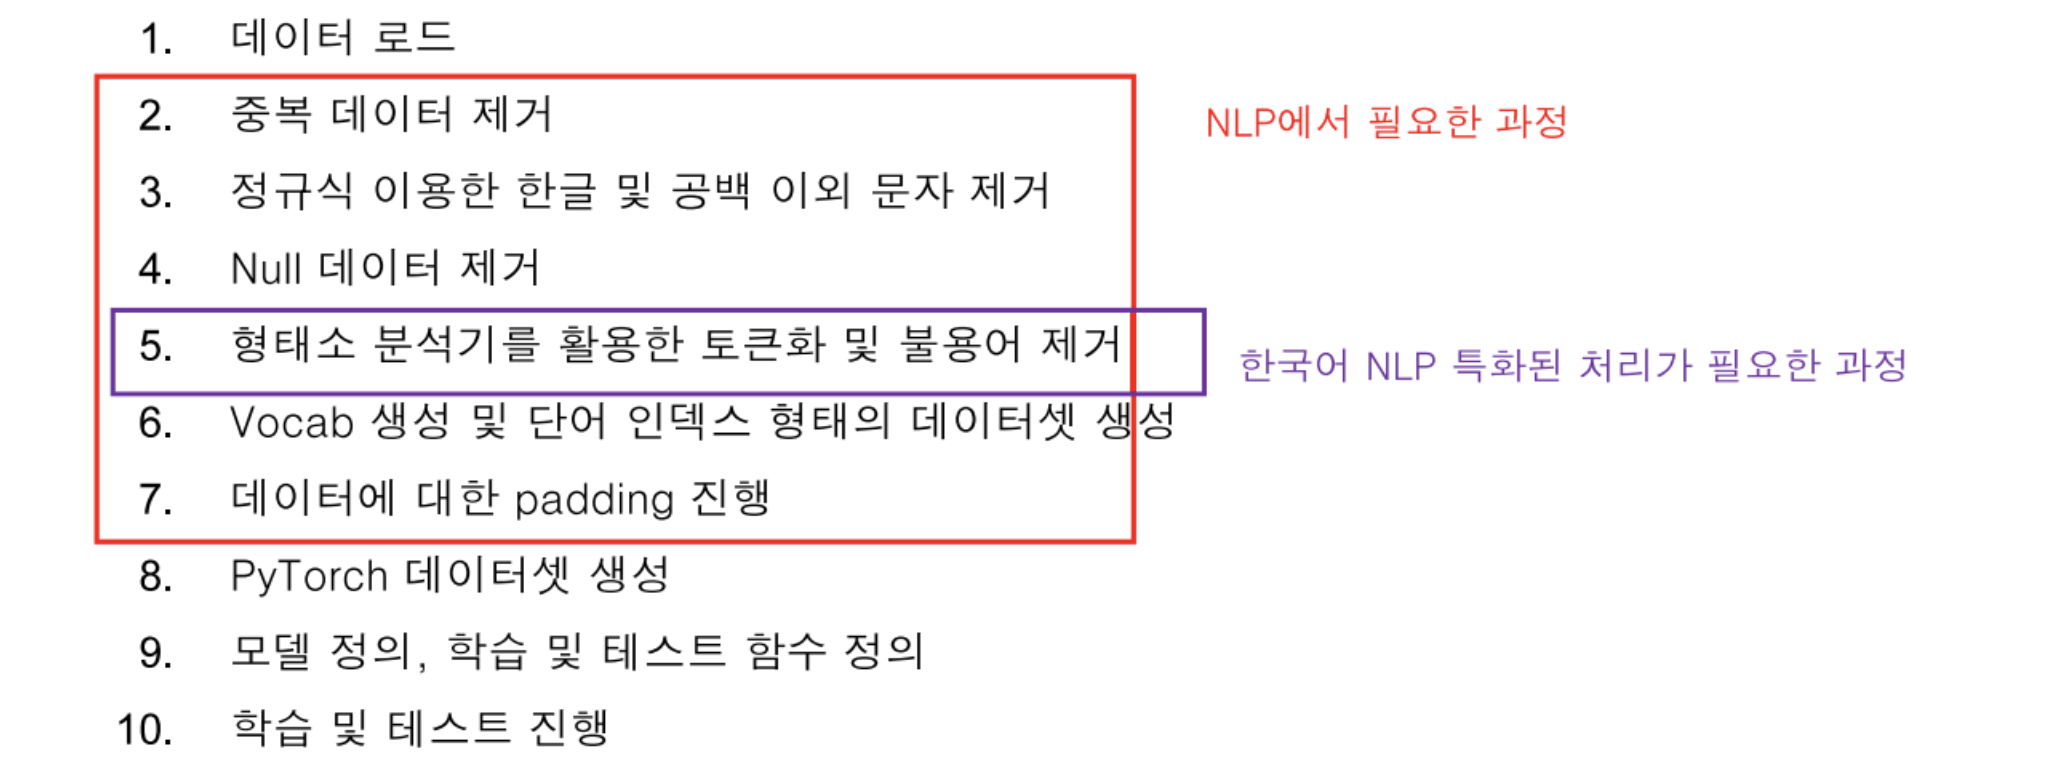